In [1]:
import os
import logging
import random
import gc
import time
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import sys
from sklearn.metrics import roc_auc_score, average_precision_score

import torch
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import json
import ast

logging.basicConfig(level=logging.ERROR)

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("cuDNN enabled:", torch.backends.cudnn.enabled)
print("Device name:", torch.cuda.get_device_name(0))
print("Tensor device:", torch.tensor([1.0], device="cuda").device)
print(torch.cuda.get_arch_list())

CUDA available: True
cuDNN enabled: True
Device name: NVIDIA H100 PCIe


/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:215: UserWarning: 
NVIDIA H100 PCIe with CUDA capability sm_90 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_60 sm_70 sm_75 compute_70 compute_75.
If you want to use the NVIDIA H100 PCIe GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


Tensor device: cuda:0
['sm_60', 'sm_70', 'sm_75', 'compute_70', 'compute_75']


In [3]:

class BirdCLEFDatasetFromNPY_Mixup(Dataset):
    def __init__(self, df, cfg, spectrograms=None, mode="train", label2idx=None, idx2label=None):
        self.df = df
        self.cfg = cfg
        self.mode = mode
        self.spectrograms = spectrograms
        self.label_to_idx = label2idx
        self.idx_to_label = idx2label
        self.species_ids = label2idx.keys() if label2idx else []
        self.num_classes = len(self.species_ids)

        if 'filepath' not in self.df.columns:
            self.df['filepath'] = self.cfg.train_datadir + '/' + self.df.filename

        if 'samplename' not in self.df.columns:
            self.df['samplename'] = self.df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

        if cfg.debug:
            self.df = self.df.sample(min(1000, len(self.df)), random_state=cfg.seed).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row1 = self.df.iloc[idx]
        spec1 = self._get_spec(row1['samplename'])
        label1 = self._get_label(row1)

        # === Mixup ===
        if self.mode == "train" and self.cfg.use_mixup and random.random() < self.cfg.mixup_prob:
            idx2 = random.randint(0, len(self.df) - 1)
            row2 = self.df.iloc[idx2]
            spec2 = self._get_spec(row2['samplename'])
            label2 = self._get_label(row2)

            lam = np.random.beta(self.cfg.mixup_alpha, self.cfg.mixup_alpha)
            spec = lam * spec1 + (1 - lam) * spec2
            label = lam * label1 + (1 - lam) * label2
        else:
            spec = spec1
            label = label1

        return {
            'melspec': spec,
            'target': torch.tensor(label, dtype=torch.float32),
            'filename': row1['filename']
        }

    def _get_spec(self, samplename):
        if self.spectrograms and samplename in self.spectrograms:
            spec = self.spectrograms[samplename]
        else:
            spec = np.zeros(self.cfg.TARGET_SHAPE, dtype=np.float32)
            if self.mode == "train":
                print(f"Warning: Spectrogram not found: {samplename}")

        spec = torch.tensor(spec, dtype=torch.float32)
        if spec.ndim == 2:
            spec = spec.unsqueeze(0)

        if self.mode == "train" and random.random() < self.cfg.aug_prob:
            spec = self.apply_spec_augmentations(spec)

        return spec
    # sec labelを分配する
    # primary labelは0.5にセット
    def _get_label(self, row):
        target = np.zeros(self.num_classes, dtype=np.float32)
        primary = row['primary_label']
        secondary_raw = row['secondary_labels']

        # secondary_labels を文字列からリストに変換
        secondary_labels = []
        if isinstance(secondary_raw, str):
            try:
                parsed = ast.literal_eval(secondary_raw)
                secondary_labels = [s for s in parsed if s.strip() != '']
            except:
                secondary_labels = []
        elif isinstance(secondary_raw, list):
            secondary_labels = [s for s in secondary_raw if s.strip() != '']

        valid_secondary = [s for s in secondary_labels if s in self.label_to_idx]

        # ラベル付け戦略に従って割り当て
        if len(valid_secondary) == 0:
            # secondaryがない → primaryに1.0
            if primary in self.label_to_idx:
                target[self.label_to_idx[primary]] = 1.0
        else:
            # secondaryがある → primaryに0.5、secondaryに0.5を均等配分
            if primary in self.label_to_idx:
                target[self.label_to_idx[primary]] = 0.5
            share = 0.5 / len(valid_secondary)
            for s in valid_secondary:
                target[self.label_to_idx[s]] = share
        return target

    def apply_spec_augmentations(self, spec):
        if random.random() < 0.5:
            for _ in range(random.randint(1, 3)):
                width = random.randint(5, 20)
                start = random.randint(0, spec.shape[2] - width)
                spec[0, :, start:start+width] = 0

        if random.random() < 0.5:
            for _ in range(random.randint(1, 3)):
                height = random.randint(5, 20)
                start = random.randint(0, spec.shape[1] - height)
                spec[0, start:start+height, :] = 0

        if random.random() < 0.5:
            gain = random.uniform(0.8, 1.2)
            bias = random.uniform(-0.1, 0.1)
            spec = spec * gain + bias
            spec = torch.clamp(spec, 0, 1)

        return spec


In [4]:
class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330' 
            self.models_dir = ""
            
            # kaggle notebookならここを変更する．
            self.train_csv = "/kaggle/input/dataset-0419/melspec_20250419_1808/train.csv"
            self.spectrogram_npy = "/kaggle/input/dataset-0419/melspec_20250419_1808/birdclef2025_melspec_5sec_256_256.npy"
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            self.train_datadir = '../data/raw/train_audio/'
            
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.pseudo_label_csv = "../data/processed/pseudo_labels/ensemble_7sec_pseudoth0.5/pseudo_label.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"

            # ローカルならここを変更する．
            self.train_csv = '../data/processed/mel_safezone1000_head/train.csv'
            self.spectrogram_npy = '../data/processed/mel_safezone1000_head/birdclef2025_melspec_5sec_256_256.npy'


        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0' # tf_efficientnetv2_b3
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.TARGET_SHAPE = (256, 256)
        
        # trainer内部で決まるのでここでは指定しない．
        self.num_classes = None


        # ===== Training Mode =====
        if mode == "train":
            self.seed = 42
            self.apex = False
            self.print_freq = 100
            self.num_workers = 2

            self.LOAD_DATA = True
            self.epochs = 7
            self.batch_size = 32
            self.criterion = 'BCEWithLogitsLoss'
            self.label_smoothing = 0.05

            self.n_fold = 5
            self.selected_folds = [0]

            self.optimizer = 'AdamW'
            self.lr = 5e-4
            self.weight_decay = 1e-5
            self.scheduler = 'CosineAnnealingLR'
            self.min_lr = 1e-6
            self.T_max = self.epochs
            self.full_train = False
            self.is_RareFull = False # レア種は全部train foldにする
            self.aug_prob = 0.5 # spec augmentの確率
            
            # mixupの設定
            self.use_mixup = True
            self.mixup_alpha = 0.4
            self.mixup_prob = 0.5
            
            self.secondary_labels = True # secondary_labelsを使うかどうか
            
            
            ## 現状使ってない．
            # self.mixup_alpha_real = 0.5
            # self.mixup_alpha_pseudo = 0.5
            self.use_pseudo_mixup = False  # pseudo lableでmixupするかどうか
            # self.pseudo_mix_prob = 0.4  # mixupでpseudo lableを使う確率
            # self.pseudo_conf_threshold = 0.5

            ###
            
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            
            if self.debug:
                self.epochs = 2
                self.selected_folds = [0]
                self.batch_size = 4
                

In [5]:
cfg = CFG(mode="train", kaggle_notebook=False, debug=False)

if cfg.KAGGLE_NOTEBOOK:
    sys.path.append("/kaggle/input/birdclef-2025-libs/")
from module import  datasets_lib, models_lib, learning_lib, utils_lib

In [6]:
# trainの処理をクラスで実行．
class BirdCLEFTrainer:
    def __init__(self, cfg, df, taxonomy_df, datasets_lib, models_lib, learning_lib):
        self.cfg = cfg
        self.df = df.head(100).reset_index(drop=True) if cfg.debug else df
        self.taxonomy_df = taxonomy_df
        self.datasets_lib = datasets_lib
        self.models_lib = models_lib
        self.learning_lib = learning_lib
        self.spectrograms = None
        self.pseudo_df = None
        self.pseudo_melspecs = None
        self.best_scores = []
        self.train_metrics = {}
        self.val_metrics = {}
        self.label2index = {}
        self.index2label = {}
        self.num_classes = None

        self._setup_model_dir()
        self._save_config()
        self._build_index_label_mapping()
        self._load_spectrograms()
        
        if self.cfg.use_pseudo_mixup:
            self._load_pseudo_data()

    def _setup_model_dir(self):
        if self.cfg.debug:
            current_time = "debug"
            self.cfg.model_path = os.path.join(self.cfg.models_dir, "models_debug")
        else:
            japan_time = datetime.now(timezone(timedelta(hours=9)))
            current_time = japan_time.strftime('%Y%m%d_%H%M')
            self.cfg.model_path = os.path.join(self.cfg.models_dir, f"models_{current_time}")

        os.makedirs(self.cfg.model_path, exist_ok=True)
        print(f"[INFO] Models will be saved to: {self.cfg.model_path}")

        # dataset-metadata.jsonを保存
        dataset_metadata = {
            "title": f"bc25-models-{current_time}",
            "id": f"ihiratch/bc25-models-{current_time}",
            "licenses": [
                {
                    "name": "CC0-1.0"
                }
            ]
        }
        metadata_path = os.path.join(self.cfg.model_path, "dataset-metadata.json")
        with open(metadata_path, "w") as f:
            json.dump(dataset_metadata, f, indent=2)

    def _save_config(self):
        cfg_dict = vars(self.cfg)
        cfg_df = pd.DataFrame(list(cfg_dict.items()), columns=["key", "value"])
        cfg_df.to_csv(os.path.join(self.cfg.model_path, "config.csv"), index=False)

    def _build_index_label_mapping(self):
        species_ids = self.taxonomy_df['primary_label'].tolist()
        self.cfg.num_classes = len(species_ids)
        # labelとindexの対応
        self.index2label = {i: label for i, label in enumerate(species_ids)}
        self.label2index = {label: i for i, label in enumerate(species_ids)}

        print(self.index2label)

    def _load_spectrograms(self):
        print(f"Loading pre-computed mel spectrograms from NPY file, from the path: {self.cfg.spectrogram_npy}")
        self.spectrograms = np.load(self.cfg.spectrogram_npy, allow_pickle=True).item()
        print(f"Loaded {len(self.spectrograms)} pre-computed mel spectrograms")
        
    def _load_pseudo_data(self):
        print("📥 Loading pseudo label CSV and melspecs...")

        # row_id を index にして読み込む（← ここがポイント！）
        self.pseudo_df = pd.read_csv(self.cfg.pseudo_label_csv, index_col="row_id")

        # 信頼度フィルタリング（例: 最大値が 0.5 未満の行を除く）
        confidence_threshold = self.cfg.pseudo_conf_threshold
        max_probs = self.pseudo_df.max(axis=1)
        self.pseudo_df = self.pseudo_df[max_probs > confidence_threshold]
        self.pseudo_df = self.pseudo_df.reset_index(drop=False)
        print(f"✅ Filtered pseudo labels: {len(self.pseudo_df)}")

        # melspec は key が row_id の dict を想定
        self.pseudo_melspecs = np.load(self.cfg.pseudo_melspec_npy, allow_pickle=True)
        print(f"✅ Loaded pseudo mel-spectrograms: {len(self.pseudo_melspecs)}")
        
    def _create_train_dataset(self, train_df):
            return BirdCLEFDatasetFromNPY_Mixup(
                    df=train_df,
                    cfg=self.cfg,
                    spectrograms=self.spectrograms,
                    mode="train",
                    label2idx=self.label2index,
                    idx2label=self.index2label 
                    )
            

    def _calculate_auc(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # 👇 ROC AUC はバイナリラベルを必要とするので、soft labelを2値化
        targets_bin = (targets >= 0.5).astype(int)

        aucs = [roc_auc_score(targets_bin[:, i], probs[:, i]) 
                for i in range(targets.shape[1]) if np.sum(targets_bin[:, i]) > 0]
        return np.mean(aucs) if aucs else 0.0

    def _calculate_classwise_auc(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # バイナリ化（連続値でもintでも安全）
        targets_bin = (targets >= 0.5).astype(int)

        classwise_auc = {}
        for i in range(targets.shape[1]):
            if np.sum(targets_bin[:, i]) > 0:
                try:
                    classwise_auc[i] = roc_auc_score(targets_bin[:, i], probs[:, i])
                except ValueError:
                    classwise_auc[i] = np.nan  # エラー出たときも安心
        return classwise_auc

    def _calculate_classwise_ap(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # ラベルをバイナリ化（soft label対応）
        targets_bin = (targets >= 0.5).astype(int)

        classwise_ap = {}
        for i in range(targets.shape[1]):
            if np.sum(targets_bin[:, i]) > 0:
                try:
                    classwise_ap[i] = average_precision_score(targets_bin[:, i], probs[:, i])
                except ValueError:
                    classwise_ap[i] = np.nan
        return classwise_ap
    
    def _calculate_map(self, targets, outputs):
        classwise_ap = self._calculate_classwise_ap(targets, outputs)
        values = [v for v in classwise_ap.values() if v is not None and not np.isnan(v)]
        return np.mean(values) if values else 0.0

    def _save_classwise_scores_to_csv(self, classwise_auc, classwise_ap, fold, filename_prefix):
        rows = []
        for i in classwise_auc:
            label = self.index2label.get(i, str(i))
            auc = classwise_auc[i]
            ap = classwise_ap.get(i, np.nan)
            rows.append({"label": label, "val_auc": auc, "val_ap": ap})
        df = pd.DataFrame(rows)
        df.to_csv(os.path.join(self.cfg.model_path, f"{filename_prefix}_classwise_score_fold{fold}.csv"), index=False)


    def train_one_epoch(self, model, loader, optimizer, criterion, device, scheduler=None):
        model.train()
        losses, all_targets, all_outputs = [], [], []

        pbar = tqdm(enumerate(loader), total=len(loader), desc="Training")
        for step, batch in pbar:
            if isinstance(batch['melspec'], list):
                batch_outputs, batch_losses = [], []
                for i in range(len(batch['melspec'])):
                    inputs = batch['melspec'][i].unsqueeze(0).to(device)
                    target = batch['target'][i].unsqueeze(0).to(device)
                    optimizer.zero_grad()
            
                    output = model(inputs)
                    loss = criterion(output, target)
                    loss.backward()
                    batch_outputs.append(output.detach().cpu())
                    batch_losses.append(loss.item())
                optimizer.step()
                outputs = torch.cat(batch_outputs, dim=0).numpy()
                loss = np.mean(batch_losses)
                targets = batch['target'].numpy()
            else:
                inputs = batch['melspec'].to(device)
                targets = batch['target'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = outputs[1] if isinstance(outputs, tuple) else criterion(outputs, targets)
                outputs = outputs[0] if isinstance(outputs, tuple) else outputs
                loss.backward()
                optimizer.step()
                outputs = outputs.detach().cpu().numpy()
                targets = targets.detach().cpu().numpy()

            if scheduler and isinstance(scheduler, lr_scheduler.OneCycleLR):
                scheduler.step()

            all_outputs.append(outputs)
            all_targets.append(targets)
            losses.append(loss.item() if not isinstance(loss, float) else loss)

            pbar.set_postfix({
                'train_loss': np.mean(losses[-10:]) if losses else 0,
                'lr': optimizer.param_groups[0]['lr']
            })

        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        self.train_metrics = {
            'train_loss': np.mean(losses),
            'train_auc': self._calculate_auc(all_targets, all_outputs),
            "train_map": self._calculate_map(all_targets, all_outputs),   
            "train_classwise_auc": self._calculate_classwise_auc(all_targets, all_outputs),
            "train_classwise_ap": self._calculate_classwise_ap(all_targets, all_outputs),  
        }

    def validate(self, model, loader, criterion, device):
        model.eval()
        losses, all_targets, all_outputs = [], [], []

        with torch.no_grad():
            for batch in tqdm(loader, desc="Validation"):
                if isinstance(batch['melspec'], list):
                    batch_outputs, batch_losses = [], []
                    for i in range(len(batch['melspec'])):
                        inputs = batch['melspec'][i].unsqueeze(0).to(device)
                        target = batch['target'][i].unsqueeze(0).to(device)
                        output = model(inputs)
                        loss = criterion(output, target)
                        batch_outputs.append(output.detach().cpu())
                        batch_losses.append(loss.item())
                    outputs = torch.cat(batch_outputs, dim=0).numpy()
                    loss = np.mean(batch_losses)
                    targets = batch['target'].numpy()
                else:
                    inputs = batch['melspec'].to(device)
                    targets = batch['target'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    outputs = outputs.detach().cpu().numpy()
                    targets = targets.detach().cpu().numpy()

                all_outputs.append(outputs)
                all_targets.append(targets)
                losses.append(loss.item() if not isinstance(loss, float) else loss)

        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        # print("Size of validation:",  len(all_targets))
        self.val_metrics = {
            'val_loss': np.mean(losses),
            'val_auc': self._calculate_auc(all_targets, all_outputs),
            "val_map": self._calculate_map(all_targets, all_outputs),
            "val_classwise_auc": self._calculate_classwise_auc(all_targets, all_outputs),
            "val_classwise_ap": self._calculate_classwise_ap(all_targets, all_outputs),
        }

    def run(self):
        
        for fold in range(self.cfg.n_fold):
            if fold not in self.cfg.selected_folds:
                continue
            print(f"\n{'='*30} Fold {fold} {'='*30}")

            # train.csvのfoldを使う．
            
            if self.cfg.full_train:
                train_df = self.df.reset_index(drop=True)
                val_df = self.df[self.df['fold'] == fold].reset_index(drop=True)
                print("Use full train data for training.")
            else:
                train_df = self.df[self.df['fold'] != fold].reset_index(drop=True)
                val_df = self.df[self.df['fold'] == fold].reset_index(drop=True) 
            
            print(f"Training set: {len(train_df)} samples")
            print(f"Validation set: {len(val_df)} samples")

            train_dataset = self._create_train_dataset(train_df)
            val_dataset = BirdCLEFDatasetFromNPY_Mixup(
                        df=val_df,
                        cfg=self.cfg,
                        spectrograms=self.spectrograms,
                        mode='valid',
                        label2idx=self.label2index,
                        idx2label=self.index2label
                    )

            train_loader = DataLoader(train_dataset, batch_size=self.cfg.batch_size, shuffle=True, 
                                       num_workers=self.cfg.num_workers, pin_memory=True,
                                       collate_fn=self.datasets_lib.collate_fn, drop_last=True)
            val_loader = DataLoader(val_dataset, batch_size=self.cfg.batch_size, shuffle=False,
                                     num_workers=self.cfg.num_workers, pin_memory=True,
                                     collate_fn=self.datasets_lib.collate_fn)

            model = self.models_lib.BirdCLEFModelForTrain(self.cfg).to(self.cfg.device)
            optimizer = self.learning_lib.get_optimizer(model, self.cfg)
            criterion = self.learning_lib.get_criterion(self.cfg)

            scheduler = (lr_scheduler.OneCycleLR(optimizer, max_lr=self.cfg.lr, 
                        steps_per_epoch=len(train_loader), epochs=self.cfg.epochs, pct_start=0.1)
                         if self.cfg.scheduler == 'OneCycleLR'
                         else self.learning_lib.get_scheduler(optimizer, self.cfg))

            best_auc = 0
            log_history = []

            for epoch in range(self.cfg.epochs):
                print(f"\nEpoch {epoch+1}/{self.cfg.epochs}")
                start_time = time.time()

                self.train_one_epoch(model, train_loader, optimizer, criterion, self.cfg.device, scheduler if isinstance(scheduler, lr_scheduler.OneCycleLR) else None)
                self.validate(model, val_loader, criterion, self.cfg.device)

                # スコア取得
                train_loss = self.train_metrics['train_loss']
                train_auc = self.train_metrics['train_auc']
                train_auc_map = self.train_metrics['train_map']

                val_loss = self.val_metrics['val_loss']
                val_auc = self.val_metrics['val_auc']
                val_auc_map = self.val_metrics['val_map']
                val_classwise_auc = self.val_metrics['val_classwise_auc']
                val_classwise_ap = self.val_metrics['val_classwise_ap']

                if scheduler and not isinstance(scheduler, lr_scheduler.OneCycleLR):
                    scheduler.step(val_loss if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau) else None)

                print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Train MAP: {train_auc_map:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val MAP: {val_auc_map:.4f}")

                if val_auc > best_auc:
                    best_auc = val_auc
                    print(f"New best AUC: {best_auc:.4f} at epoch {epoch+1}")
                    
                    self._save_classwise_scores_to_csv(val_classwise_auc, val_classwise_ap, fold, filename_prefix="best_val")

                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'epoch': epoch,
                        'val_auc': val_auc,
                        'train_auc': train_auc,
                        "index2label": self.index2label,
                        'cfg': self.cfg
                    }, f"{self.cfg.model_path}/model_fold{fold}.pth")

                log_entry = {
                    'epoch': epoch + 1,
                    'lr': scheduler.get_last_lr()[0] if scheduler else self.cfg.lr,
                    'epoch_time_min': round((time.time() - start_time) / 60, 2)
                }

                # classwiseスコアを除外した val_metrics のログ
                train_log = {f"{k}": v for k, v in self.train_metrics.items() if not k.startswith("train_classwise")}
                val_log = {f"{k}": v for k, v in self.val_metrics.items() if not k.startswith("val_classwise")}
                
                # ログ用スコアの更新（classwiseは除外）
                log_entry.update(train_log)
                log_entry.update(val_log)
                log_history.append(log_entry)
            
           
                

            pd.DataFrame(log_history).to_csv(f"{self.cfg.model_path}/log_fold{fold}.csv", index=False)
            self.best_scores.append(best_auc)
            print(f"\nBest AUC for fold {fold}: {best_auc:.4f}")

            del model, optimizer, scheduler, train_loader, val_loader
            torch.cuda.empty_cache()
            gc.collect()

        print("\n" + "="*60)
        print("Cross-Validation Results:")
        for fold, score in enumerate(self.best_scores):
            print(f"Fold {self.cfg.selected_folds[fold]}: {score:.4f}")
        print(f"Mean AUC: {np.mean(self.best_scores):.4f}")
        print("="*60)



In [7]:
# レア種はfold=-1にする．
def overwrite_fold_for_rare_classes(df, rare_threshold=5):
    # 各ラベルの出現数をカウント
    label_counts = df.groupby('primary_label').size()

    # rareなラベルをリストアップ
    rare_labels = label_counts[label_counts < rare_threshold].index.tolist()

    print(f"Rare labels ({len(rare_labels)} classes): {rare_labels[:10]}{'...' if len(rare_labels) > 10 else ''}")

    # rareなラベルのデータだけ fold = -1 に上書き
    df.loc[df['primary_label'].isin(rare_labels), 'fold'] = -1

    return df



In [8]:
# モデルはmodels_{current_time}に保存される．
if __name__ == "__main__":
    utils_lib.set_seed(cfg.seed)
    print("\nLoading training data...")
    train_df = pd.read_csv(cfg.train_csv)
    
    if not cfg.secondary_labels:
        print("secondary_labels is not used.")
        train_df["secondary_labels"] = "['']"
    
    if cfg.is_RareFull: 
        print("Rare species are all in train fold.")
        train_df = overwrite_fold_for_rare_classes(train_df, rare_threshold=5)
        
    # taxonomyはラベルとindexの対応を取るために必要．
    taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
    print("\nStarting training...")
    trainer = BirdCLEFTrainer(cfg, train_df, taxonomy_df,  datasets_lib, models_lib, learning_lib)
    trainer.run()
    print("\nTraining complete!")


Loading training data...

Starting training...
[INFO] Models will be saved to: ../models/models_20250506_1956
{0: '1139490', 1: '1192948', 2: '1194042', 3: '126247', 4: '1346504', 5: '134933', 6: '135045', 7: '1462711', 8: '1462737', 9: '1564122', 10: '21038', 11: '21116', 12: '21211', 13: '22333', 14: '22973', 15: '22976', 16: '24272', 17: '24292', 18: '24322', 19: '41663', 20: '41778', 21: '41970', 22: '42007', 23: '42087', 24: '42113', 25: '46010', 26: '47067', 27: '476537', 28: '476538', 29: '48124', 30: '50186', 31: '517119', 32: '523060', 33: '528041', 34: '52884', 35: '548639', 36: '555086', 37: '555142', 38: '566513', 39: '64862', 40: '65336', 41: '65344', 42: '65349', 43: '65373', 44: '65419', 45: '65448', 46: '65547', 47: '65962', 48: '66016', 49: '66531', 50: '66578', 51: '66893', 52: '67082', 53: '67252', 54: '714022', 55: '715170', 56: '787625', 57: '81930', 58: '868458', 59: '963335', 60: 'amakin1', 61: 'amekes', 62: 'ampkin1', 63: 'anhing', 64: 'babwar', 65: 'bafibi1', 

Training:   0%|          | 0/713 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0334, Train AUC: 0.6193, Train MAP: 0.0120
Val Loss: 0.0213, Val AUC: 0.8552, Val MAP: 0.1240
New best AUC: 0.8552 at epoch 1

Epoch 2/7


Training:   0%|          | 0/713 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0200, Train AUC: 0.8663, Train MAP: 0.1342
Val Loss: 0.0153, Val AUC: 0.9328, Val MAP: 0.3415
New best AUC: 0.9328 at epoch 2

Epoch 3/7


Training:   0%|          | 0/713 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0163, Train AUC: 0.9320, Train MAP: 0.2725
Val Loss: 0.0128, Val AUC: 0.9540, Val MAP: 0.4605
New best AUC: 0.9540 at epoch 3

Epoch 4/7


Training:   0%|          | 0/713 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0143, Train AUC: 0.9517, Train MAP: 0.3821
Val Loss: 0.0118, Val AUC: 0.9599, Val MAP: 0.5298
New best AUC: 0.9599 at epoch 4

Epoch 5/7


Training:   0%|          | 0/713 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0125, Train AUC: 0.9731, Train MAP: 0.5072
Val Loss: 0.0108, Val AUC: 0.9651, Val MAP: 0.5803
New best AUC: 0.9651 at epoch 5

Epoch 6/7


Training:   0%|          | 0/713 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50e02de050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50e02de050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/op

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0114, Train AUC: 0.9790, Train MAP: 0.6035
Val Loss: 0.0102, Val AUC: 0.9670, Val MAP: 0.6099
New best AUC: 0.9670 at epoch 6

Epoch 7/7


Training:   0%|          | 0/713 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0106, Train AUC: 0.9837, Train MAP: 0.6547
Val Loss: 0.0101, Val AUC: 0.9679, Val MAP: 0.6194
New best AUC: 0.9679 at epoch 7

Best AUC for fold 0: 0.9679

Cross-Validation Results:
Fold 0: 0.9679
Mean AUC: 0.9679

Training complete!


In [9]:

import os
model_dir_name = "fold0_SecLabel_distribute"
model_dir = os.path.join(cfg.models_dir, model_dir_name)

# スコア格納辞書（foldごとの記録）
score_lists = {
    'val_auc': [],
    'train_auc': [],
    'val_map': [],
    'train_map': [],
    'val_loss': [],
    'train_loss': [],
    'epoch': [],
}

# 各foldのベストスコア収集
for fold in range(5):
    log_path = os.path.join(model_dir, f"log_fold{fold}.csv")
    if not os.path.exists(log_path):
        print(f"Missing log for fold {fold}: {log_path}")
        continue

    df = pd.read_csv(log_path)
    best_row = df.loc[df['val_auc'].idxmax()]

    print(f"Fold {fold} best epoch: {int(best_row['epoch'])}, val_auc: {best_row['val_auc']:.3f}, train_auc: {best_row['train_auc']:.3f}")

    for key in score_lists:
        score_lists[key].append(best_row[key])

# 平均スコアを整形（.3fで表示、epochだけ.2f）
score_means = {}
for key, values in score_lists.items():
    avg = sum(values) / len(values)
    display_key = f"Avg {key.replace('_', ' ').title()}"
    if "epoch" in key:
        score_means[display_key] = f"{avg:.2f}"
    else:
        score_means[display_key] = f"{avg:.3f}"

# config.csv 読み込み
config_path = os.path.join(model_dir, "config.csv")
config_df = pd.read_csv(config_path)

important_keys = [
    'model_name','batch_size', 'epochs',
    'optimizer', 'lr', 'weight_decay', 'scheduler', 'min_lr', "tta",
]

# config情報の統合
config_dict = {"Note": "", "LB AUC": "", **score_means }
for key in important_keys:
    value = config_df.loc[config_df['key'] == key, 'value'].values
    config_dict[key] = value[0] if len(value) > 0 else ""

# Markdown出力
all_keys = list(config_dict.keys())
print("\n```markdown")
print("| " + " | ".join(all_keys) + " |")
print("|" + "|".join(["-" * (len(k)+2) for k in all_keys]) + "|")
print("| " + " | ".join(str(config_dict[k]) for k in all_keys) + " |")
print("```")
df


Fold 0 best epoch: 7, val_auc: 0.968, train_auc: 0.984
Missing log for fold 1: ../models/fold0_SecLabel_distribute/log_fold1.csv
Missing log for fold 2: ../models/fold0_SecLabel_distribute/log_fold2.csv
Missing log for fold 3: ../models/fold0_SecLabel_distribute/log_fold3.csv
Missing log for fold 4: ../models/fold0_SecLabel_distribute/log_fold4.csv

```markdown
| Note | LB AUC | Avg Val Auc | Avg Train Auc | Avg Val Map | Avg Train Map | Avg Val Loss | Avg Train Loss | Avg Epoch | model_name | batch_size | epochs | optimizer | lr | weight_decay | scheduler | min_lr | tta |
|------|--------|-------------|---------------|-------------|---------------|--------------|----------------|-----------|------------|------------|--------|-----------|----|--------------|-----------|--------|-----|
|  |  | 0.968 | 0.984 | 0.619 | 0.655 | 0.010 | 0.011 | 7.00 | efficientnet_b0 | 32 | 7 | AdamW | 0.0005 | 1e-05 | CosineAnnealingLR | 1e-06 |  |
```


,epoch,lr,epoch_time_min,train_loss,train_auc,train_map,val_loss,val_auc,val_map
0,1,0.000475,1.76,0.033444,0.619257,0.011994,0.021344,0.855219,0.124011
1,2,0.000406,1.73,0.019968,0.866319,0.134167,0.015294,0.932788,0.341541
2,3,0.000306,1.73,0.016274,0.932024,0.272538,0.012839,0.954049,0.460467
3,4,0.000195,1.73,0.014291,0.951652,0.382095,0.011764,0.959854,0.529847
4,5,0.000095,1.57,0.012517,0.973063,0.507183,0.010762,0.965099,0.580289
5,6,0.000026,1.73,0.011405,0.979023,0.603470,0.010213,0.967040,0.609900
6,7,0.000001,1.73,0.010606,0.983701,0.654712,0.010058,0.967920,0.619425


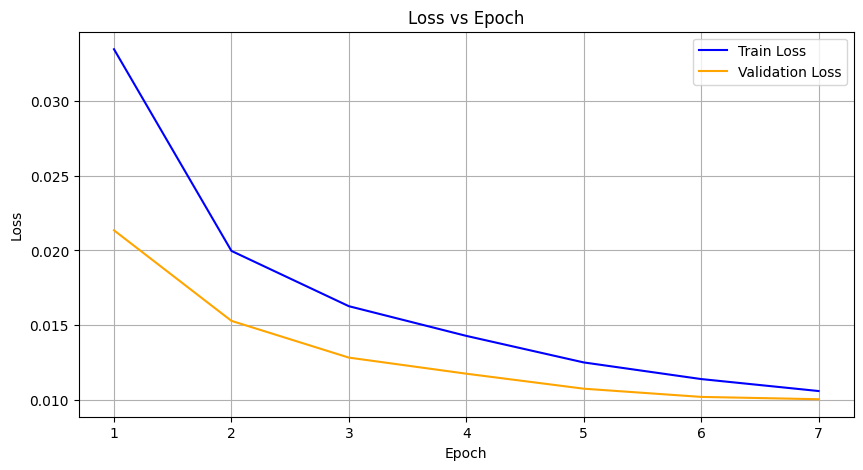

In [10]:

model_dir_name = "fold0_SecLabel_distribute"
i = 0
model_dir = os.path.join(cfg.models_dir, model_dir_name)
log_path = os.path.join(model_dir, f"log_fold{i}.csv")

# lossをプロット
df = pd.read_csv(log_path)
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()


In [ ]:
# モデル出力チェック

# モデルパス
# 比較元
model_1_path = "../models/fold0_RemVoice0426_epch6//model_fold0.pth"
model_2_path = "../models/fold0_RemVoiceMan0426_epch6//model_fold0.pth"

# 共通設定（このcfg_infは必須）
cfg_inf = CFG(mode="inference", kaggle_notebook=False)
num_classes = train_df['primary_label'].nunique()


# モデル読み込み関数
def load_model(path):
    model = models_lib.BirdCLEFModelForInference(cfg_inf, num_classes)
    checkpoint = torch.load(path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

# モデル読み込み
model_1 = load_model(model_1_path)
model_2 = load_model(model_2_path)

# 同じダミー入力
dummy_input = torch.randn(1, 1, 256, 256)

# 推論（出力に sigmoid が必要な場合は model に含まれてるか確認して適宜追加）
with torch.no_grad():
    out_0413 = model_1(dummy_input).numpy()
    out_0420 = model_2(dummy_input).numpy()

# 差分計算
abs_diff = np.abs(out_0413 - out_0420)
print("🔍 PyTorch モデル出力比較:")
print(f"最大誤差: {np.max(abs_diff)}")
print(f"平均誤差: {np.mean(abs_diff)}")
print(f"標準偏差: {np.std(abs_diff)}")

🔍 PyTorch モデル出力比較:
最大誤差: 5.95980167388916
平均誤差: 1.857330560684204
標準偏差: 1.2556836605072021


In [ ]:
# エポック1でデバッグできる.


In [ ]:
log_1_path = "../models/epch1_cleaned_0413/log_fold0.csv"
log_2_path = "../models/models_20250422_1826/log_fold0.csv"

log_1 = pd.read_csv(log_1_path)
log_2 = pd.read_csv(log_2_path)

df = pd.DataFrame()
df["train_loss_1"] = log_1["train_loss"]
df["train_loss_2"] = log_2["train_loss"]

df["val_loss_1"] = log_1["val_loss"]
df["val_loss_2"] = log_2["val_loss"]

df["val_auc_1"] = log_1["val_auc"]
df["val_auc_2"] = log_2["val_auc"]

df

FileNotFoundError: [Errno 2] No such file or directory: '../models/models_20250422_1826/log_fold0.csv'